# Scattering

## 1. Morlet Wavelet

In [146]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


In [147]:
def Morlet2d(u, theta = 0, sigma = 0.85, xi = 3 * np.pi / 4):
    return np.exp(1j * xi * u) * np.exp(-np.abs(u)**2 / (2 * sigma**2))
    #revoir toute la fonction!!!

def Morlet2d_centered(u, theta = 0,  sigma = 0.85, xi = 3 * np.pi / 4):
    time1 = time.time()
    integral_real = integrate.quad(lambda t : np.real(Morlet(t, theta, sigma, xi)), -np.inf, np.inf)[0]
    integral_gaus = integrate.quad(lambda t : np.exp(-np.absolute(t)**2 / (2 * sigma**2)), -np.inf, np.inf)[0]
    integral_imag = integrate.quad(lambda t : np.imag(Morlet(t, sigma, xi)), -np.inf, np.inf)[0]
    beta = integral_real / integral_gaus + 1j * integral_imag / integral_gaus
    time2 = time.time()
    return Morlet(u, sigma, xi) - beta * np.exp(-u**2 / (2 * sigma**2))

### Representation (bien moche mais tout de même)
et il faut revoir les fonctions définies ci dessus pour que ça marche

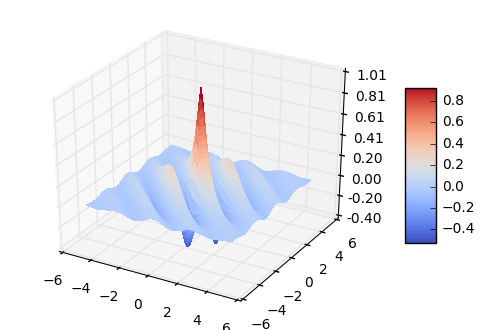

In [148]:
sigma = 0.85
xi = 3 * np.pi / 4
fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = np.real(np.exp(1j * xi * (X + Y)))
Z *= np.exp(-np.sqrt(X**2 + Y**2) / (2 * sigma**2))
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap = cm.coolwarm,
        linewidth=0, antialiased=False)
ax.set_zlim(-0.4, 1.01)


ax.zaxis.set_major_locator(LinearLocator(8))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## 2. Convolution
